# Get Data and Forming Combinations (DONE)

In [1]:
import pandas as pd
import yfinance as yf
from typing import List, Dict, Tuple
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
import os
from statsmodels.tsa.api import AutoReg
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
import psycopg2
import time
from datetime import timedelta
from helper import *

In [4]:
class DataHandler:
    """Handles stock data loading and clustering for statistical arbitrage.

    Args:
        futures (str): Futures ticker symbol (e.g., 'VN30F1M').
        stocks (list): List of stock ticker symbols (excluding ETFs).
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        estimation_window (int, optional): Window size for residual computation. Defaults to 60.
        cluster_update_interval (int, optional): Days between cluster updates. Defaults to 3.
        futures_change_threshold (float, optional): Threshold for futures price change. Defaults to 0.05.
        max_clusters (int, optional): Maximum number of clusters. Defaults to 10.
        etf_list (list, optional): List of ETF ticker symbols. Defaults to None.
        etf_included (bool, optional): Whether to include ETFs in clustering. Defaults to True.

    Attributes:
        futures (str): Futures ticker symbol.
        stocks (list): List of stock ticker symbols (excluding ETFs).
        start_date (str): Start date.
        end_date (str): End date.
        estimation_window (int): Window size for residuals.
        cluster_update_interval (int): Days between cluster updates.
        futures_change_threshold (float): Threshold for futures price change.
        max_clusters (int): Maximum number of clusters.
        etf_list (list): List of ETF ticker symbols.
        etf_included (bool): Whether ETFs are included in clustering.
        data (pd.DataFrame): Loaded price data.
        last_clusters (list): Last computed clusters.
        last_cluster_day (datetime): Date of last cluster update.
        last_futures_price (float): Last futures price.
    """

    def __init__(self, futures, stocks, start_date, end_date, 
                 estimation_window=60, cluster_update_interval=3, 
                 futures_change_threshold=0.05, max_clusters=10,
                 etf_list=None, etf_included=True):
        self.futures = futures
        # Ensure stocks list does not include ETFs
        self.etf_list = etf_list if etf_list is not None else []
        self.stocks = [s for s in stocks if s not in self.etf_list]  # Filter out ETFs from stocks
        self.start_date = start_date
        self.end_date = end_date
        self.estimation_window = estimation_window
        self.cluster_update_interval = cluster_update_interval
        self.futures_change_threshold = futures_change_threshold
        self.max_clusters = max_clusters
        self.etf_included = etf_included
        self.data = self.load_data()
        self.last_clusters = None
        self.last_cluster_day = None
        self.last_futures_price = None

    def load_data(self):
        """Load price data for futures, stocks, and optionally ETFs.

        Returns:
            pd.DataFrame: Cleaned price data with no missing values.
        """
        # Load data for futures and stocks
        symbols_to_load = [self.futures] + self.stocks
        # If ETFs are included, add them to the symbols to load
        if self.etf_included:
            symbols_to_load.extend(self.etf_list)
        data = get_stock_data(symbols_to_load, self.start_date, self.end_date)
        return data.dropna()

    def compute_residuals(self, window_data):
        """Compute residuals from OLS regression of stocks (and ETFs if included) against futures.

        Args:
            window_data (pd.DataFrame): Price data for the estimation window.

        Returns:
            pd.DataFrame: Residuals for each stock/ETF.
        """
        residuals = pd.DataFrame(index=window_data.index)
        # Compute residuals for stocks and ETFs (if included)
        symbols = self.stocks
        if self.etf_included:
            symbols = symbols + self.etf_list
        for symbol in symbols:
            if symbol in window_data.columns:
                X = sm.add_constant(window_data[self.futures])
                y = window_data[symbol]
                model = sm.OLS(y, X).fit()
                residuals[symbol] = model.resid
        return residuals.dropna()

    def cluster_stocks(self, window_data, current_day, futures_current_price):
        """Cluster stocks based on residuals using KMeans, with optional ETF handling.

        Args:
            window_data (pd.DataFrame): Price data for the estimation window.
            current_day (datetime): Current date for clustering.
            futures_current_price (float): Current futures price.

        Returns:
            list: List of stock clusters.
        """
        if (self.last_clusters is not None and self.last_cluster_day is not None):
            days_since_last_cluster = (current_day - self.last_cluster_day).days
            futures_change = (abs(futures_current_price - self.last_futures_price) / 
                              self.last_futures_price if self.last_futures_price else 0)
            if (days_since_last_cluster < self.cluster_update_interval and 
                futures_change < self.futures_change_threshold):
                return self.last_clusters
        
        residuals = self.compute_residuals(window_data)
        if residuals.empty or len(residuals.columns) < 2:
            # If residuals are empty or too few symbols, return all symbols as one cluster
            symbols = self.stocks
            if self.etf_included:
                symbols = symbols + self.etf_list
            self.last_clusters = [symbols]
        else:
            # Separate ETFs and stocks based on etf_included flag
            if self.etf_included:
                # Include ETFs, but cluster them separately
                etf_list = self.etf_list
                stock_list = self.stocks  # Already filtered in __init__
            else:
                # Exclude ETFs entirely
                etf_list = []
                stock_list = self.stocks
            
            clusters = []
            # Cluster non-ETFs
            if stock_list:
                X = residuals[stock_list].T
                best_k = min(2, len(stock_list))  # Ensure at least 2 if possible
                best_score = -1
                for k in range(2, min(self.max_clusters + 1, len(stock_list))):
                    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
                    if kmeans.n_clusters > 1:
                        score = silhouette_score(X, kmeans.labels_)
                        if score > best_score:
                            best_score = score
                            best_k = k
                kmeans = KMeans(n_clusters=best_k, random_state=0).fit(X)
                stock_clusters = {i: [] for i in range(best_k)}
                for stock, label in zip(stock_list, kmeans.labels_):
                    stock_clusters[label].append(stock)
                clusters.extend([c for c in stock_clusters.values() if c])
            # Add ETFs as a separate cluster if included
            if self.etf_included and etf_list:
                clusters.append(etf_list)
            
            self.last_clusters = clusters
        
        self.last_cluster_day = current_day
        self.last_futures_price = futures_current_price
        return self.last_clusters
class StatArbStrategy:    
    """A class to implement a statistical arbitrage strategy using cointegration.

    This class identifies cointegrated combinations of futures and stocks, validates them,
    and tracks active combinations over time to generate trading signals.

    Args:
        data_handler: An object handling data access (futures, stocks, and historical data).
        min_trading_days (int, optional): Minimum trading days before re-evaluating a combination. Defaults to 45.
        threshold (float, optional): Minimum beta threshold for stock inclusion. Defaults to 0.05.
        max_stocks (int, optional): Maximum number of stocks in a combination. Defaults to 10.
        confidence_level (int, optional): Confidence level for Johansen cointegration test. Defaults to 1.
        adf_significance (float, optional): Significance level for ADF test. Defaults to 0.05.
        correlation_threshold (float, optional): Threshold for residual correlation to avoid duplicates. Defaults to 0.6.
        dynamic_threshold (bool, optional): Whether to dynamically adjust correlation threshold. Defaults to True.
        residual_threshold (float, optional): Threshold for residual size relative to futures price. Defaults to 0.3.
        improvement_threshold (float, optional): Minimum improvement in trace statistic for adding a stock. Defaults to 0.03.

    Attributes:
        active_combinations (list): List of currently active cointegrated combinations.
        combination_id (int): Unique identifier for combinations.
        results (list): List of results for each day and combination.
        validation_cache (dict): Cache for validation results to avoid redundant computations.
    """
    def __init__(self, data_handler, min_trading_days=45, threshold=0.05,
                 max_stocks=10, confidence_level=1, adf_significance=0.05,
                 correlation_threshold=0.6, dynamic_threshold=True,
                 residual_threshold=0.3, improvement_threshold=0.03):
        self.data_handler = data_handler
        self.futures = data_handler.futures
        self.stocks = data_handler.stocks
        self.estimation_window = data_handler.estimation_window
        self.data = data_handler.data
        self.min_trading_days = min_trading_days
        self.threshold = threshold
        self.max_stocks = max_stocks
        self.confidence_level = confidence_level
        self.confidence_level_joh_final = min(2, confidence_level + 1)
        self.adf_significance = adf_significance
        self.adf_significance_trading = min(0.1, 2 * adf_significance)
        self.correlation_threshold = correlation_threshold
        self.dynamic_threshold = dynamic_threshold
        self.residual_threshold = residual_threshold
        self.improvement_threshold = improvement_threshold
        self.active_combinations = []
        self.combination_id = 0
        self.results = []
        self.validation_cache = {}

    def get_pairwise_candidates(self, window_data, stocks_pool):
        """Identifies stocks that are cointegrated with the futures using pairwise Johansen tests.

        Args:
            window_data (pd.DataFrame): Historical data for the estimation window.
            stocks_pool (list): List of stock symbols to test for cointegration.

        Returns:
            list: Sorted list of stock symbols that are cointegrated with the futures, ranked by trace statistic.
        """
        candidates = []
        for stock in stocks_pool:
            try:
                result = coint_johansen(window_data[[self.futures, stock]], det_order=1, k_ar_diff=1)
                if result.lr1[0] > result.cvt[0, self.confidence_level]:
                    candidates.append((stock, result.lr1[0]))
            except Exception as e:
                print(f"Pairwise test failed for {stock}: {e}")
        candidates.sort(key=lambda x: x[1], reverse=True)
        return [stock for stock, _ in candidates]

    def build_combination_greedy(self, window_data, candidates):
        """Greedily builds a cointegrated combination of stocks with the futures, trying multiple starting points.

        Args:
            window_data (pd.DataFrame): Historical data for the estimation window.
            candidates (list): List of candidate stock symbols.

        Returns:
            list: List of selected stock symbols forming a cointegrated combination.
        """
        if not candidates:
            return []
        best_selected = []
        best_trace_stat = -np.inf
        for start_stock in candidates[:3]:  # Try top 3 starting points
            selected = [start_stock]
            current_trace_stat = coint_johansen(window_data[[self.futures, start_stock]], det_order=1, k_ar_diff=1).lr1[0]
            for stock in [s for s in candidates if s != start_stock]:
                if len(selected) >= self.max_stocks:
                    break
                test_subset = selected + [stock]
                try:
                    result = coint_johansen(window_data[[self.futures] + test_subset], det_order=1, k_ar_diff=1)
                    if result.lr1[0] <= result.cvt[0, self.confidence_level]:
                        continue
                    improvement = (result.lr1[0] - current_trace_stat) / current_trace_stat
                    if improvement < self.improvement_threshold:    
                        continue
                    evec = result.evec[:, 0]
                    betas = -evec[1:] / evec[0]
                    if not all(beta >= 0 for beta in betas):
                        continue
                    selected.append(stock)
                    current_trace_stat = result.lr1[0]
                except Exception as e:
                    print(f"Combination test failed: {e}")
            if current_trace_stat > best_trace_stat:
                best_trace_stat = current_trace_stat
                best_selected = selected[:]
        return best_selected

    def validate_combination(self, window_data, selected):
        """Validates a combination by checking cointegration, beta positivity, stationarity, and residual size.

        Args:
            window_data (pd.DataFrame): Historical data for the estimation window.
            selected (list): List of selected stock symbols.

        Returns:
            tuple: (combination_params, adf_pvalue) where combination_params is a dict with intercept and betas,
                   or (None, np.inf) if validation fails.
        """
        comb_key = frozenset(selected)
        if comb_key in self.validation_cache:
            return self.validation_cache[comb_key]
        try:
            result = coint_johansen(window_data[[self.futures] + list(selected)], det_order=1, k_ar_diff=1)
            if result.lr1[0] <= result.cvt[0, self.confidence_level_joh_final]:
                self.validation_cache[comb_key] = (None, np.inf)
                return None, np.inf
            evec = result.evec[:, 0]
            betas = -evec[1:] / evec[0]
            if not all(beta >= 0 for beta in betas):
                self.validation_cache[comb_key] = (None, np.inf)
                return None, np.inf
            
            synthetic_portfolio = sum(window_data[s] * b for s, b in zip(selected, betas))
            residuals = window_data[self.futures] - synthetic_portfolio
            intercept = -residuals.mean()
            adf_pvalue = adfuller(residuals)[1]
            if adf_pvalue >= self.adf_significance:
                self.validation_cache[comb_key] = (None, adf_pvalue)
                return None, adf_pvalue
            futures_avg = window_data[self.futures].mean()
            if np.percentile(np.abs(residuals), 95) > self.residual_threshold * futures_avg:
                self.validation_cache[comb_key] = (None, adf_pvalue)
                return None, adf_pvalue
            selected_betas = {s: b for s, b in zip(selected, betas) if abs(b) > self.threshold}
            combination_params = {'intercept': intercept, 'betas': selected_betas}
            self.validation_cache[comb_key] = (combination_params, adf_pvalue)
            return combination_params, adf_pvalue
        except Exception as e:
            print(f"Validation failed for {selected}: {e}")
            self.validation_cache[comb_key] = (None, np.inf)
            return None, np.inf

    def is_similar(self, new_residuals, existing_residuals):
        """Checks if two sets of residuals are similar based on correlation.

        Args:
            new_residuals (pd.Series): Residuals of a new combination.
            existing_residuals (pd.Series): Residuals of an existing combination.

        Returns:
            bool: True if residuals are similar (correlation above threshold), False otherwise.
        """
        if len(new_residuals) != len(existing_residuals):
            return False
        corr, _ = pearsonr(new_residuals, existing_residuals)
        return corr > self.correlation_threshold

    def adjust_correlation_threshold(self):
        """Dynamically adjusts the correlation threshold based on the number of active combinations.

        If there are fewer than 10 active combinations, increases the threshold; otherwise, decreases it.
        """
        if self.dynamic_threshold:
            if len(self.active_combinations) < 10:
                self.correlation_threshold = min(0.8, self.correlation_threshold + 0.05)
            else:
                self.correlation_threshold = max(0.5, self.correlation_threshold - 0.05)

    def run_strategy(self):
        """Runs the statistical arbitrage strategy over the entire dataset.

        Identifies cointegrated combinations, validates them, and tracks residuals over time.
        Updates active combinations and logs results.
        """
        for day in range(self.estimation_window, len(self.data)):
            estimation_data = self.data.iloc[day - self.estimation_window:day]
            current_day = self.data.index[day]
            futures_current_price = self.data.iloc[day][self.futures]
            self.adjust_correlation_threshold()
            clusters = self.data_handler.cluster_stocks(estimation_data, current_day, futures_current_price)

            for cluster in clusters:
                candidates = self.get_pairwise_candidates(estimation_data, cluster)
                selected = self.build_combination_greedy(estimation_data, candidates)
                if selected:
                    params, new_adf_pvalue = self.validate_combination(estimation_data, selected)
                    if params:
                        self.add_combination_if_not_similar(params, new_adf_pvalue, estimation_data, current_day)

            top_candidates = []
            for cluster in clusters:
                cluster_candidates = self.get_pairwise_candidates(estimation_data, cluster)[:3]
                top_candidates.extend(cluster_candidates)
            top_candidates = list(set(top_candidates))

            if top_candidates:
                cross_selected = self.build_combination_greedy(estimation_data, top_candidates)
                if cross_selected:
                    cross_params, cross_adf_pvalue = self.validate_combination(estimation_data, cross_selected)
                    if cross_params:
                        self.add_combination_if_not_similar(cross_params, cross_adf_pvalue, estimation_data, current_day)

            all_candidates = self.get_pairwise_candidates(estimation_data, self.stocks)
            cross_selected = self.build_combination_greedy(estimation_data, all_candidates)
            if cross_selected:
                cross_params, cross_adf_pvalue = self.validate_combination(estimation_data, cross_selected)
                if cross_params:
                    self.add_combination_if_not_similar(cross_params, cross_adf_pvalue, estimation_data, current_day)

            for comb in self.active_combinations[:]:
                if day < comb['start_day']:
                    continue
                comb['trading_days'] += 1
                current_prices = self.data.iloc[day]
                synthetic_portfolio = sum(current_prices[s] * b for s, b in comb['params']['betas'].items())
                residual = current_prices[self.futures] - (comb['params']['intercept'] + synthetic_portfolio)
                comb['all_residuals'].append(residual)
                if comb['trading_days'] >= self.min_trading_days:
                    recent_residuals = pd.Series(comb['all_residuals'][-self.estimation_window:])
                    if adfuller(recent_residuals)[1] >= self.adf_significance_trading:
                        self.active_combinations.remove(comb)
                        continue
                row = {
                    'Date': current_day,
                    'Combination_ID': comb['id'],
                    'Residual': residual,
                    'Total_Combinations': len(self.active_combinations),
                    'Num_Stocks': len(comb['params']['betas']),
                    'Is_Estimation': False,
                    'Intercept': comb['params']['intercept'],
                    **{f'Beta_{s}': b for s, b in comb['params']['betas'].items()}
                }
                self.results.append(row)

    def add_combination_if_not_similar(self, params, new_adf_pvalue, estimation_data, current_day):
        """Adds a new combination if its residuals are not similar to existing ones.

        Args:
            params (dict): Parameters of the new combination (intercept and betas).
            new_adf_pvalue (float): ADF p-value of the new combination's residuals.
            estimation_data (pd.DataFrame): Historical data for the estimation window.
            current_day (pd.Timestamp): Current date in the backtest.
        """
        synthetic_portfolio = sum(estimation_data[s] * b for s, b in params['betas'].items())
        residuals = estimation_data[self.futures] - (params['intercept'] + synthetic_portfolio)
        similar_found = False
        to_remove = []
        for comb in self.active_combinations:
            existing_residuals = pd.Series(comb['all_residuals'][-self.estimation_window:])
            if self.is_similar(residuals, existing_residuals):
                if comb['trading_days'] >= self.min_trading_days:
                    existing_adf_pvalue = adfuller(existing_residuals)[1]
                    if new_adf_pvalue < 0.5 * existing_adf_pvalue:
                        to_remove.append(comb)
                else:
                    similar_found = True
        for comb in to_remove:
            self.active_combinations.remove(comb)
        if not similar_found:
            self.combination_id += 1
            self.active_combinations.append({
                'id': self.combination_id,
                'params': params,
                'start_day': self.data.index.get_loc(current_day),
                'all_residuals': residuals.tolist(),
                'trading_days': 0
            })
            for i, res in enumerate(residuals):
                row = {
                    'Date': estimation_data.index[i],
                    'Combination_ID': self.combination_id,
                    'Residual': res,
                    'Total_Combinations': len(self.active_combinations),
                    'Num_Stocks': len(params['betas']),
                    'Is_Estimation': True,
                    'Intercept': params['intercept'],
                    **{f'Beta_{s}': b for s, b in params['betas'].items()}
                }
                self.results.append(row)
            print(f"\n=== New Combination {self.combination_id} at {current_day.date()} ===")
            print(f"VN30F1M = {params['intercept']:.3f} + " + " + ".join([f"{b:.3f}*{s}" for s, b in params['betas'].items()]))

    def get_results(self):
        """Returns the results of the strategy as a DataFrame and the stock price data.

        Returns:
            tuple: (results_df, stock_price) where results_df is a DataFrame of results and stock_price is the price data.
        """
        results_df = pd.DataFrame(self.results)
        # Add all stocks to results_df with 0 betas for non-combination stocks
        for stock in self.stocks:
            beta_col = f'Beta_{stock}'
            if beta_col not in results_df.columns:
                results_df[beta_col] = 0.0
        results_df = results_df.sort_values(by=['Combination_ID', 'Date'])
        stock_price = self.data
        return results_df, stock_price



In [5]:
stocks=['ACB', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 'KDH', 'MBB', 'MSN', 'MWG', 'NVL', 'PDR', 'PLX', 'PNJ', 'POW', 'SAB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE']
futures='VN30F1M'
start_date='2021-06-01'
end_date='2022-07-31'
etf_list = ['FUEVFVND', 'FUESSVFL', 'E1VFVN30', 'FUEVN100']


# Initialize DataHandler with ETF list and etf_included flag
data_handler = DataHandler(
    futures=futures,
    stocks=stocks, 
    start_date=start_date,
    end_date=end_date,
    etf_list=etf_list,
    etf_included=False  # Set to False to exclude ETFs entirely
)

# Run the strategy
strategy = StatArbStrategy(data_handler)
strategy.run_strategy()
results_df_1, stock_price = strategy.get_results()



=== New Combination 1 at 2021-08-31 ===
VN30F1M = -168.184 + 4.803*SAB + 68.361*TPB + 1.096*TCB

=== New Combination 2 at 2021-09-14 ===
VN30F1M = -83.201 + 11.706*TCB + 23.085*PLX

=== New Combination 3 at 2021-09-27 ===
VN30F1M = -189.259 + 1.046*HPG + 9.036*KDH + 3.977*PLX + 26.369*CTG

=== New Combination 4 at 2021-11-11 ===
VN30F1M = -156.143 + 0.903*MSN + 3.314*VIC + 2.862*VRE + 1.057*MWG + 1.287*VHM + 10.330*VPB + 7.312*HPG + 7.952*HDB + 1.972*CTG

=== New Combination 5 at 2021-11-12 ===
VN30F1M = 196.922 + 9.932*NVL + 5.497*VJC + 1.515*MSN

=== New Combination 6 at 2021-12-28 ===
VN30F1M = 399.657 + 4.705*VCB + 21.776*VPB + 14.406*FPT + 5.433*POW + 1.994*VRE + 3.367*VHM

=== New Combination 7 at 2022-01-12 ===
VN30F1M = -173.773 + 14.126*VCB + 4.367*POW + 11.931*VPB + 17.513*MBB + 2.949*GVR

=== New Combination 8 at 2022-02-09 ===
VN30F1M = 114.314 + 20.806*MWG + 16.456*HDB

=== New Combination 9 at 2022-02-16 ===
VN30F1M = -118.978 + 7.559*HDB + 10.542*SSI + 6.322*VCB + 6.196

In [ ]:
# results_df_1.to_csv('draft\\results.csv', index=False)

# Generating Trading Signal 

##( Chưa có add in cái cơ sở bị lock 2 ngày), combination khi mua sẽ bị lock 2 ngày rồi mới coi behvior của s-score

In [6]:
class SignalGenerator:
    """Generates trading signals by fitting an Ornstein-Uhlenbeck (OU) process to residuals.

    Args:
        residuals (pd.DataFrame): Pivot table of residuals with dates as index and combination IDs as columns.
        ou_window (int, optional): Window size for fitting the OU process. Defaults to 60.
        fallback_days (int, optional): Number of days to use previous OU parameters if fitting fails. Defaults to 5.

    Attributes:
        ou_params (pd.DataFrame): DataFrame storing OU parameters (kappa, m, sigma, s_score) for each combination.
        last_valid_params (dict): Stores the last valid OU parameters for each combination.
        ou_cache (dict): Cache for OU fitting results to avoid redundant computations.
    """
    def __init__(self, residuals: pd.DataFrame, ou_window: int = 60, fallback_days: int = 5):
        self.residuals = residuals
        self.ou_window = ou_window
        self.fallback_days = fallback_days
        self.ou_params = None
        self.last_valid_params = {col: None for col in residuals.columns}
        self.ou_cache = {}

    def fit_ou_process(self, series: pd.Series, date: pd.Timestamp) -> Dict[str, float]:
        """Fits an Ornstein-Uhlenbeck process to a series of residuals and computes the s-score.

        Args:
            series (pd.Series): Residual series for a combination.
            date (pd.Timestamp): Current date for caching purposes.

        Returns:
            dict: OU parameters {'kappa': float, 'm': float, 'sigma': float, 's_score': float}.
                  Returns NaN values if fitting fails.
        """
        cache_key = (series.name, date)
        if cache_key in self.ou_cache:
            return self.ou_cache[cache_key]
        if len(series) < self.ou_window:
            return {'kappa': np.nan, 'm': np.nan, 'sigma': np.nan, 's_score': np.nan}
        series_window = series[-self.ou_window:].dropna().to_numpy()
        if len(series_window) < self.ou_window:
            return {'kappa': np.nan, 'm': np.nan, 'sigma': np.nan, 's_score': np.nan}
        try:
            model = AutoReg(series_window, lags=1).fit()
            a, b = model.params
            p_value_b = model.pvalues[1]
            if p_value_b >= 0.10 or b <= 0 or b >= 1:
                return {'kappa': np.nan, 'm': np.nan, 'sigma': np.nan, 's_score': np.nan}
            kappa = -np.log(b) * np.sqrt(252)
            m = a / (1 - b)
            sigma = np.sqrt(model.sigma2 * 2 * kappa / (1 - b**2))
            latest = series.iloc[-1]
            sigma_eq = sigma / np.sqrt(2 * kappa) if kappa > 0 else np.inf
            s_score = (latest - m) / sigma_eq if sigma_eq != 0 else 0
            params = {'kappa': kappa, 'm': m, 'sigma': sigma, 's_score': s_score}
            self.ou_cache[cache_key] = params
            return params
        except (ValueError, np.linalg.LinAlgError):
            return {'kappa': np.nan, 'm': np.nan, 'sigma': np.nan, 's_score': np.nan}

    def apply_ou_fitting(self):
        """Applies OU process fitting to all residual series over time.

        Updates the ou_params DataFrame with kappa, m, sigma, and s_score for each combination and date.
        """
        columns = pd.MultiIndex.from_product([self.residuals.columns, ['kappa', 'm', 'sigma', 's_score']])
        self.ou_params = pd.DataFrame(index=self.residuals.index, columns=columns)
        for t in range(self.ou_window, len(self.residuals)):
            date = self.residuals.index[t]
            for stock in self.residuals.columns:
                series = self.residuals[stock].iloc[:t + 1]
                params = self.fit_ou_process(series, date)
                if not np.isnan(params['kappa']):
                    self.last_valid_params[stock] = {'params': params, 'date': date}
                elif self.last_valid_params[stock] and (date - self.last_valid_params[stock]['date']).days <= self.fallback_days:
                    last_params = self.last_valid_params[stock]['params']
                    latest = series.iloc[-1]
                    m, kappa, sigma = last_params['m'], last_params['kappa'], last_params['sigma']
                    sigma_eq = sigma / np.sqrt(2 * kappa) if kappa > 0 else np.inf
                    params['s_score'] = (latest - m) / sigma_eq if sigma_eq != 0 else 0
                for param, value in params.items():
                    self.ou_params.loc[date, (stock, param)] = value

def get_allocation_tier(s_score: float, prev_allocation: float, prev_s_score: float, is_decreasing_trend: bool) -> float:
    """Determines the allocation tier based on the s-score and trend.

    Args:
        s_score (float): Current s-score from the OU process.
        prev_allocation (float): Previous allocation percentage.
        prev_s_score (float): Previous s-score.
        is_decreasing_trend (bool): Whether the s-score is decreasing.

    Returns:
        float: Allocation percentage for the current s-score tier.
    """
    if s_score > 2.0 or s_score < -1.5:
        return 0.0
    elif s_score > 1.5 and s_score > prev_s_score:
        return 1.2
    elif s_score > 1.25 and s_score > prev_s_score:
        return 1
    elif s_score > 1.0: 
        return 0.8
    elif prev_allocation > 0:
        if s_score < 1.0 and s_score < prev_s_score:
            return max(0.0, prev_allocation - 0.1)
        elif s_score > prev_s_score and is_decreasing_trend:
            return max(0.0, prev_allocation - 0.2)
        else:
            return prev_allocation
    return 0.0

def generate_signals(residuals_pivot: pd.DataFrame, ou_window: int = 60) -> pd.DataFrame:
    """Generates OU-based trading signals from residuals.

    Args:
        residuals_pivot (pd.DataFrame): Pivot table of residuals with dates as index and combination IDs as columns.
        ou_window (int, optional): Window size for OU process fitting. Defaults to 60.

    Returns:
        pd.DataFrame: DataFrame with OU parameters (kappa, m, sigma, s_score) for each combination and date.
    """
    signal_gen = SignalGenerator(residuals_pivot, ou_window=ou_window)
    signal_gen.apply_ou_fitting()
    return signal_gen.ou_params

def compute_allocations(ou_params: pd.DataFrame, residuals_pivot: pd.DataFrame, ou_window: int = 60) -> pd.DataFrame:
    """Computes allocation percentages based on OU s-scores.

    Args:
        ou_params (pd.DataFrame): DataFrame with OU parameters (kappa, m, sigma, s_score).
        residuals_pivot (pd.DataFrame): Pivot table of residuals.
        ou_window (int, optional): Window size for OU process fitting. Defaults to 60.

    Returns:
        pd.DataFrame: DataFrame with allocation percentages for each combination and date.
    """
    allocation_percentages = pd.DataFrame(index=ou_params.index, columns=residuals_pivot.columns, dtype=float).fillna(0.0)
    trend_tracker = {comb_id: False for comb_id in residuals_pivot.columns}

    for comb_id in allocation_percentages.columns:
        s_scores = ou_params[(comb_id, 's_score')]
        prev_allocation = 0.0
        prev_s_score = np.nan
        for i, date in enumerate(s_scores.index):
            if i < ou_window:
                allocation = 0.0
            else:
                s_score = s_scores[date]
                if pd.isna(s_score) or pd.isna(residuals_pivot.loc[date, comb_id]):
                    allocation = 0.0
                else:
                    is_decreasing = s_score < prev_s_score if not pd.isna(prev_s_score) else False
                    trend_tracker[comb_id] = is_decreasing
                    allocation = get_allocation_tier(s_score, prev_allocation, prev_s_score, trend_tracker[comb_id])
                    prev_s_score = s_score if not pd.isna(s_score) else prev_s_score
            allocation_percentages.loc[date, comb_id] = allocation
            prev_allocation = allocation
    return allocation_percentages

def calculate_positions(allocation_percentages: pd.DataFrame, results_df: pd.DataFrame, stock_price: pd.DataFrame, stocks: list) -> pd.DataFrame:
    """Calculates trading positions based on allocation percentages.

    Args:
        allocation_percentages (pd.DataFrame): DataFrame with allocation percentages.
        results_df (pd.DataFrame): DataFrame with combination results (betas, residuals, etc.).
        stock_price (pd.DataFrame): DataFrame with stock and futures prices.
        stocks (list): List of stock symbols.

    Returns:
        pd.DataFrame: DataFrame with positions for VN30F1M and each stock, including absolute values.
    """
    dates = results_df['Date'].sort_values().unique()
    columns = ['Total_Port_Trading', 'VN30F1M_Position'] + [f'{stock}_Position' for stock in stocks] + ['Num_Active_Combinations', 'Active_Combination_IDs']
    positions_df = pd.DataFrame(index=dates, columns=columns, dtype=float)
    positions_df['Active_Combination_IDs'] = positions_df['Active_Combination_IDs'].astype(object)
    positions_df = positions_df.fillna(0.0)

    for date in dates:
        if date not in allocation_percentages.index:
            continue
        active_combs = allocation_percentages.loc[date][allocation_percentages.loc[date] > 0]
        num_active = len(active_combs)
        active_ids = list(active_combs.index)
        positions_df.loc[date, 'Num_Active_Combinations'] = num_active
        positions_df.loc[date, 'Active_Combination_IDs'] = str(active_ids)

        if num_active == 0:
            total_allocation = 0.0
        else:
            base_allocation = min(0.6 + 0.1 * (num_active - 1), 1.0)
            intended_allocations = active_combs * base_allocation
            total_intended = intended_allocations.sum()
            scale_factor = 1.0 / total_intended if total_intended > 1.0 else 1.0
            scaled_allocations = intended_allocations * scale_factor
            total_allocation = scaled_allocations.sum()

        positions_df.loc[date, 'Total_Port_Trading'] = total_allocation
        positions_df.loc[date, 'VN30F1M_Position'] = -total_allocation * 0.20  # 20% short

        stock_allocation = total_allocation * 0.80  # 80% to stocks
        for comb_id in active_combs.index:
            comb_allocation = scaled_allocations[comb_id] * stock_allocation / total_allocation if total_allocation > 0 else 0
            comb_row = results_df[(results_df['Date'] == date) & (results_df['Combination_ID'] == comb_id)]
            if comb_row.empty or date not in stock_price.index:
                continue

            comb_stocks = [s for s in stocks if f'Beta_{s}' in comb_row.columns and comb_row[f'Beta_{s}'].values[0] >= 0]
            sum_beta_price = 0.0
            valid_comb_stocks = []
            for s in comb_stocks:
                beta = comb_row[f'Beta_{s}'].values[0]
                price = stock_price.loc[date, s] if s in stock_price.columns and not pd.isna(stock_price.loc[date, s]) else np.nan
                if not pd.isna(price):
                    sum_beta_price += beta * price
                    valid_comb_stocks.append(s)

            if sum_beta_price > 0:
                for stock in valid_comb_stocks:
                    beta = comb_row[f'Beta_{stock}'].values[0]
                    current_price = stock_price.loc[date, stock]
                    stock_proportion = (beta * current_price) / sum_beta_price
                    stock_position = comb_allocation * stock_proportion
                    positions_df.loc[date, f'{stock}_Position'] += stock_position

    return positions_df

def process_results_df(results_df: pd.DataFrame, stock_price: pd.DataFrame, stocks: list, ou_window: int = 60) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Processes the results DataFrame to generate signals, allocations, positions, and trading logs.

    Args:
        results_df (pd.DataFrame): DataFrame with combination results.
        stock_price (pd.DataFrame): DataFrame with stock and futures prices.
        stocks (list): List of stock symbols.
        ou_window (int, optional): Window size for OU process fitting. Defaults to 60.

    Returns:
        tuple: (results_df, positions_df, trading_log) where:
            - results_df: Updated results with s-scores and allocations.
            - positions_df: DataFrame with trading positions.
            - trading_log: DataFrame with trading actions and deltas.
    """
    results_df = results_df.sort_values('Date')
    residuals_pivot = results_df.pivot(index='Date', columns='Combination_ID', values='Residual')
    ou_params = generate_signals(residuals_pivot, ou_window=ou_window)
    allocation_percentages = compute_allocations(ou_params, residuals_pivot, ou_window=ou_window)
    positions_df = calculate_positions(allocation_percentages, results_df, stock_price, stocks)

    # Add s-scores and allocations to results_df
    results_df['s_score'] = results_df.apply(
        lambda row: ou_params.loc[row['Date'], (row['Combination_ID'], 's_score')]
        if row['Date'] in ou_params.index else np.nan, axis=1
    )
    results_df['Allocation'] = results_df.apply(
        lambda row: allocation_percentages.loc[row['Date'], row['Combination_ID']]
        if row['Date'] in allocation_percentages.index else 0.0, axis=1
    )

    # Add absolute values to positions_df
    for date in positions_df.index:
        if date in stock_price.index and not pd.isna(stock_price.loc[date, 'VN30F1M']):
            vn30_pos = positions_df.loc[date, 'VN30F1M_Position']
            positions_df.loc[date, 'Abs_VN30F1M'] = abs(vn30_pos) * stock_price.loc[date, 'VN30F1M']
            total_abs_stocks = 0.0
            for stock in stocks:
                stock_pos = positions_df.loc[date, f'{stock}_Position']
                if stock_pos > 0:
                    stock_price_val = stock_price.loc[date, stock]
                    positions_df.loc[date, f'Abs_{stock}'] = stock_pos * stock_price_val
                    total_abs_stocks += stock_pos * stock_price_val
                else:
                    positions_df.loc[date, f'Abs_{stock}'] = 0.0
            positions_df.loc[date, 'Abs_Stocks'] = total_abs_stocks
        else:
            positions_df.loc[date, 'Abs_VN30F1M'] = np.nan
            positions_df.loc[date, 'Abs_Stocks'] = np.nan
            for stock in stocks:
                positions_df.loc[date, f'Abs_{stock}'] = np.nan

    # Generate trading log
    trading_log = pd.DataFrame(index=positions_df.index)
    trading_log['Total_Port_Trading'] = positions_df['Total_Port_Trading']
    trading_log['Delta_VN30F1M'] = positions_df['VN30F1M_Position'].diff().fillna(0.0)
    trading_log['Action_VN30F1M'] = np.where(
        (trading_log['Delta_VN30F1M'] > 0) & (positions_df['VN30F1M_Position'].shift(1).fillna(0.0) < 0), 'buy to cover',
        np.where(trading_log['Delta_VN30F1M'] < 0, 'sell short', 'hold')
    )
    for stock in stocks:
        pos_col = f'{stock}_Position'
        delta_col = f'Delta_{stock}'
        action_col = f'Action_{stock}'
        trading_log[delta_col] = positions_df[pos_col].diff().fillna(0.0)
        trading_log[action_col] = np.where(
            trading_log[delta_col] > 0, 'buy',
            np.where(trading_log[delta_col] < 0, 'sell', 'hold')
        )
    trading_log['Num_Active_Combinations'] = positions_df['Num_Active_Combinations']
    trading_log['Active_Combination_IDs'] = positions_df['Active_Combination_IDs']

    # Round values
    for df in [positions_df, trading_log]:
        for col in df.columns:
            if col.startswith(('Total_Port_Trading', 'VN30F1M_Position', 'Delta_VN30F1M', 'Abs_VN30F1M', 'Abs_Stocks')) or col.endswith('_Position') or col.startswith('Delta_') or col.startswith('Abs_'):
                df[col] = df[col].apply(lambda x: round(x, 4) if pd.notna(x) and abs(x) > 1e-10 else 0.0)

    # Sort indices
    results_df.sort_values(by=['Combination_ID', 'Date'], inplace=True)
    positions_df.sort_index(inplace=True)
    trading_log.sort_index(inplace=True)

    return results_df, positions_df, trading_log

In [ ]:
# Lock-up 2 day period but fail

# import pandas as pd
# import numpy as np
# from typing import Dict, Tuple
# from collections import defaultdict, deque
# from statsmodels.tsa.api import AutoReg

# class SignalGenerator:
#     def __init__(self, residuals: pd.DataFrame, ou_window: int = 60, fallback_days: int = 5):
#         self.residuals = residuals
#         self.ou_window = ou_window
#         self.fallback_days = fallback_days
#         self.ou_params = None
#         self.last_valid_params = {col: None for col in residuals.columns}
#         self.ou_cache = {}

#     def fit_ou_process(self, series: pd.Series, date: pd.Timestamp) -> Dict[str, float]:
#         cache_key = (series.name, date)
#         if cache_key in self.ou_cache:
#             return self.ou_cache[cache_key]
#         if len(series) < self.ou_window:
#             return {'kappa': np.nan, 'm': np.nan, 'sigma': np.nan, 's_score': np.nan}
#         series_window = series[-self.ou_window:].dropna().to_numpy()
#         if len(series_window) < self.ou_window:
#             return {'kappa': np.nan, 'm': np.nan, 'sigma': np.nan, 's_score': np.nan}
#         try:
#             model = AutoReg(series_window, lags=1).fit()
#             a, b = model.params
#             p_value_b = model.pvalues[1]
#             if p_value_b >= 0.10 or b <= 0 or b >= 1:
#                 return {'kappa': np.nan, 'm': np.nan, 'sigma': np.nan, 's_score': np.nan}
#             kappa = -np.log(b) * np.sqrt(252)
#             m = a / (1 - b)
#             sigma = np.sqrt(model.sigma2 * 2 * kappa / (1 - b**2))
#             latest = series.iloc[-1]
#             sigma_eq = sigma / np.sqrt(2 * kappa) if kappa > 0 else np.inf
#             s_score = (latest - m) / sigma_eq if sigma_eq != 0 else 0
#             params = {'kappa': kappa, 'm': m, 'sigma': sigma, 's_score': s_score}
#             self.ou_cache[cache_key] = params
#             return params
#         except (ValueError, np.linalg.LinAlgError):
#             return {'kappa': np.nan, 'm': np.nan, 'sigma': np.nan, 's_score': np.nan}

#     def apply_ou_fitting(self):
#         columns = pd.MultiIndex.from_product([self.residuals.columns, ['kappa', 'm', 'sigma', 's_score']])
#         self.ou_params = pd.DataFrame(index=self.residuals.index, columns=columns)
#         for t in range(self.ou_window, len(self.residuals)):
#             date = self.residuals.index[t]
#             for stock in self.residuals.columns:
#                 series = self.residuals[stock].iloc[:t + 1]
#                 params = self.fit_ou_process(series, date)
#                 if not np.isnan(params['kappa']):
#                     self.last_valid_params[stock] = {'params': params, 'date': date}
#                 elif self.last_valid_params[stock] and (date - self.last_valid_params[stock]['date']).days <= self.fallback_days:
#                     last_params = self.last_valid_params[stock]['params']
#                     latest = series.iloc[-1]
#                     m, kappa, sigma = last_params['m'], last_params['kappa'], last_params['sigma']
#                     sigma_eq = sigma / np.sqrt(2 * kappa) if kappa > 0 else np.inf
#                     params['s_score'] = (latest - m) / sigma_eq if sigma_eq != 0 else 0
#                 for param, value in params.items():
#                     self.ou_params.loc[date, (stock, param)] = value

# def get_allocation_tier(s_score: float, prev_allocation: float, prev_s_score: float, is_decreasing_trend: bool) -> float:
#     if s_score > 2.0 or s_score < -1.5:
#         return 0.0
#     elif s_score > 1.5 and s_score > prev_s_score:
#         return 1.2
#     elif s_score > 1.25 and s_score > prev_s_score:
#         return 1.0
#     elif s_score > 1.0: 
#         return 0.8
#     elif prev_allocation > 0:
#         if s_score < 1.0 and s_score < prev_s_score:
#             return max(0.0, prev_allocation - 0.1)
#         elif s_score > prev_s_score and is_decreasing_trend:
#             return max(0.0, prev_allocation - 0.2)
#         else:
#             return prev_allocation
#     return 0.0

# def generate_signals(residuals_pivot: pd.DataFrame, ou_window: int = 60) -> pd.DataFrame:
#     signal_gen = SignalGenerator(residuals_pivot, ou_window=ou_window)
#     signal_gen.apply_ou_fitting()
#     return signal_gen.ou_params

# def compute_allocations(ou_params: pd.DataFrame, residuals_pivot: pd.DataFrame, ou_window: int = 60) -> pd.DataFrame:
#     allocation_percentages = pd.DataFrame(index=ou_params.index, columns=residuals_pivot.columns, dtype=float).fillna(0.0)
#     trend_tracker = {comb_id: False for comb_id in residuals_pivot.columns}  # Track decreasing trend per combination

#     for comb_id in allocation_percentages.columns:
#         s_scores = ou_params[(comb_id, 's_score')]
#         prev_allocation = 0.0
#         prev_s_score = np.nan
#         for i, date in enumerate(s_scores.index):
#             if i < ou_window:
#                 allocation = 0.0
#             else:
#                 s_score = s_scores[date]
#                 if pd.isna(s_score) or pd.isna(residuals_pivot.loc[date, comb_id]):
#                     allocation = 0.0
#                 else:
#                     # Determine if s-score is decreasing
#                     is_decreasing = s_score < prev_s_score if not pd.isna(prev_s_score) else False
#                     trend_tracker[comb_id] = is_decreasing
#                     allocation = get_allocation_tier(s_score, prev_allocation, prev_s_score, trend_tracker[comb_id])
#                     prev_s_score = s_score if not pd.isna(s_score) else prev_s_score
#             allocation_percentages.loc[date, comb_id] = allocation
#             prev_allocation = allocation
#     return allocation_percentages

# class PositionTracker:
#     def __init__(self):
#         self.positions = defaultdict(lambda: deque())  # {asset: deque([(date, qty), ...])}

#     def add_position(self, asset: str, date: pd.Timestamp, qty: float):
#         if qty != 0:  # Handle both buys (>0) and shorts (<0)
#             self.positions[asset].append((date, qty))

#     def get_available(self, asset: str, current_date: pd.Timestamp, lockup_days: int = 2) -> float:
#         available = 0.0
#         for purchase_date, qty in list(self.positions[asset]):
#             days_held = (current_date - purchase_date).days
#             if days_held >= lockup_days:
#                 available += qty
#         return available

#     def adjust_position(self, asset: str, current_date: pd.Timestamp, target_qty: float, lockup_days: int = 2):
#         available = self.get_available(asset, current_date, lockup_days)
#         current_total = sum(qty for _, qty in self.positions[asset])
#         delta = target_qty - current_total

#         if delta > 0:  # Buy more stocks or cover shorts (VN30F1M)
#             self.add_position(asset, current_date, delta)
#         elif delta < 0:  # Sell stocks or increase short (VN30F1M)
#             # For stocks (positive positions), sell only available shares
#             # For VN30F1M (negative positions), buy to cover only available shorts
#             if current_total > 0:  # Stocks
#                 available_to_sell = max(0, available)  # Available to sell (positive)
#                 sell_amount = min(abs(delta), available_to_sell)
#                 remaining_sell = sell_amount
#             else:  # VN30F1M (short position)
#                 available_to_cover = min(0, available)  # Available to cover (negative)
#                 cover_amount = min(abs(delta), abs(available_to_cover))
#                 remaining_sell = cover_amount  # Here, "sell" means buying to cover

#             while remaining_sell > 0 and self.positions[asset]:
#                 purchase_date, qty = self.positions[asset][0]
#                 days_held = (current_date - purchase_date).days
#                 if days_held >= lockup_days:
#                     if qty > 0:  # Selling stocks
#                         if qty <= remaining_sell:
#                             self.positions[asset].popleft()
#                             remaining_sell -= qty
#                         else:
#                             self.positions[asset][0] = (purchase_date, qty - remaining_sell)
#                             remaining_sell = 0
#                     else:  # Covering VN30F1M shorts
#                         if abs(qty) <= remaining_sell:
#                             self.positions[asset].popleft()
#                             remaining_sell -= abs(qty)
#                         else:
#                             self.positions[asset][0] = (purchase_date, qty + remaining_sell)
#                             remaining_sell = 0
#                 else:
#                     break

#     def get_position(self, asset: str) -> float:
#         return sum(qty for _, qty in self.positions[asset])

# def calculate_positions(allocation_percentages: pd.DataFrame, results_df: pd.DataFrame, stock_price: pd.DataFrame, stocks: list) -> pd.DataFrame:
#     dates = results_df['Date'].sort_values().unique()
#     columns = ['Total_Port_Trading', 'VN30F1M_Position'] + [f'{stock}_Position' for stock in stocks] + ['Num_Active_Combinations', 'Active_Combination_IDs']
#     positions_df = pd.DataFrame(index=dates, columns=columns, dtype=float)
#     positions_df['Active_Combination_IDs'] = positions_df['Active_Combination_IDs'].astype(object)
#     positions_df = positions_df.fillna(0.0)

#     tracker = PositionTracker()
#     stock_targets = {stock: 0.0 for stock in stocks}  # Track desired positions

#     for date in dates:
#         if date not in allocation_percentages.index:
#             continue
#         active_combs = allocation_percentages.loc[date][allocation_percentages.loc[date] > 0]
#         num_active = len(active_combs)
#         active_ids = list(active_combs.index)
#         positions_df.loc[date, 'Num_Active_Combinations'] = num_active
#         positions_df.loc[date, 'Active_Combination_IDs'] = str(active_ids)

#         # Reset stock targets for the day
#         for stock in stocks:
#             stock_targets[stock] = 0.0

#         if num_active == 0:
#             total_allocation = 0.0
#         else:
#             total_allocation = min(0.6 + 0.1 * (num_active - 1), 1.0)
#             equal_allocation_per_comb = total_allocation / num_active
#             # Update allocation_percentages to reflect equal split
#             for comb_id in active_combs.index:
#                 allocation_percentages.loc[date, comb_id] = equal_allocation_per_comb

#         positions_df.loc[date, 'Total_Port_Trading'] = total_allocation
#         target_vn30 = -total_allocation * 0.20  # 20% short
#         tracker.adjust_position('VN30F1M', date, target_vn30)
#         positions_df.loc[date, 'VN30F1M_Position'] = tracker.get_position('VN30F1M')

#         stock_allocation = total_allocation * 0.80  # 80% to stocks
#         for comb_id in active_combs.index:
#             comb_allocation = equal_allocation_per_comb * stock_allocation / total_allocation if total_allocation > 0 else 0
#             comb_row = results_df[(results_df['Date'] == date) & (results_df['Combination_ID'] == comb_id)]
#             if comb_row.empty or date not in stock_price.index:
#                 continue

#             comb_stocks = [s for s in stocks if f'Beta_{s}' in comb_row.columns and comb_row[f'Beta_{s}'].values[0] >= 0]
#             sum_beta_price = 0.0
#             valid_comb_stocks = []
#             for s in comb_stocks:
#                 beta = comb_row[f'Beta_{s}'].values[0]
#                 price = stock_price.loc[date, s] if s in stock_price.columns and not pd.isna(stock_price.loc[date, s]) else np.nan
#                 if not pd.isna(price):
#                     sum_beta_price += beta * price
#                     valid_comb_stocks.append(s)

#             if sum_beta_price > 0:
#                 for stock in valid_comb_stocks:
#                     beta = comb_row[f'Beta_{stock}'].values[0]
#                     current_price = stock_price.loc[date, stock]
#                     stock_proportion = (beta * current_price) / sum_beta_price
#                     stock_position = comb_allocation * stock_proportion
#                     stock_targets[stock] += stock_position

#         # Adjust stock positions with T+1.5 constraint
#         for stock in stocks:
#             target_stock_pos = stock_targets[stock]
#             tracker.adjust_position(stock, date, target_stock_pos)
#             positions_df.loc[date, f'{stock}_Position'] = tracker.get_position(stock)

#     return positions_df

# def process_results_df(results_df: pd.DataFrame, stock_price: pd.DataFrame, stocks: list, ou_window: int = 60) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
#     results_df = results_df.sort_values('Date')
#     residuals_pivot = results_df.pivot(index='Date', columns='Combination_ID', values='Residual')
#     ou_params = generate_signals(residuals_pivot, ou_window=ou_window)
#     allocation_percentages = compute_allocations(ou_params, residuals_pivot, ou_window=ou_window)
#     positions_df = calculate_positions(allocation_percentages, results_df, stock_price, stocks)

#     results_df['s_score'] = results_df.apply(
#         lambda row: ou_params.loc[row['Date'], (row['Combination_ID'], 's_score')]
#         if row['Date'] in ou_params.index else np.nan, axis=1
#     )
#     results_df['Allocation'] = results_df.apply(
#         lambda row: allocation_percentages.loc[row['Date'], row['Combination_ID']]
#         if row['Date'] in allocation_percentages.index else 0.0, axis=1
#     )

#     for date in positions_df.index:
#         if date in stock_price.index and not pd.isna(stock_price.loc[date, 'VN30F1M']):
#             vn30_pos = positions_df.loc[date, 'VN30F1M_Position']
#             positions_df.loc[date, 'Abs_VN30F1M'] = abs(vn30_pos) * stock_price.loc[date, 'VN30F1M']
#             total_abs_stocks = 0.0
#             for stock in stocks:
#                 stock_pos = positions_df.loc[date, f'{stock}_Position']
#                 if stock_pos > 0:
#                     stock_price_val = stock_price.loc[date, stock]
#                     positions_df.loc[date, f'Abs_{stock}'] = stock_pos * stock_price_val if not pd.isna(stock_price_val) else 0.0
#                     total_abs_stocks += stock_pos * stock_price_val if not pd.isna(stock_price_val) else 0.0
#                 else:
#                     positions_df.loc[date, f'Abs_{stock}'] = 0.0
#             positions_df.loc[date, 'Abs_Stocks'] = total_abs_stocks
#         else:
#             positions_df.loc[date, 'Abs_VN30F1M'] = np.nan
#             positions_df.loc[date, 'Abs_Stocks'] = np.nan
#             for stock in stocks:
#                 positions_df.loc[date, f'Abs_{stock}'] = np.nan

#     trading_log = pd.DataFrame(index=positions_df.index)
#     trading_log['Total_Port_Trading'] = positions_df['Total_Port_Trading']
#     trading_log['Delta_VN30F1M'] = positions_df['VN30F1M_Position'].diff().fillna(0.0)
#     trading_log['Action_VN30F1M'] = np.where(
#         (trading_log['Delta_VN30F1M'] > 0) & (positions_df['VN30F1M_Position'].shift(1).fillna(0.0) < 0), 'buy to cover',
#         np.where(trading_log['Delta_VN30F1M'] < 0, 'sell short', 'hold')
#     )
#     for stock in stocks:
#         pos_col = f'{stock}_Position'
#         delta_col = f'Delta_{stock}'
#         action_col = f'Action_{stock}'
#         trading_log[delta_col] = positions_df[pos_col].diff().fillna(0.0)
#         trading_log[action_col] = np.where(
#             trading_log[delta_col] > 0, 'buy',
#             np.where(trading_log[delta_col] < 0, 'sell', 'hold')
#         )
#     trading_log['Num_Active_Combinations'] = positions_df['Num_Active_Combinations']
#     trading_log['Active_Combination_IDs'] = positions_df['Active_Combination_IDs']

#     for df in [positions_df, trading_log]:
#         for col in df.columns:
#             if col.startswith(('Total_Port_Trading', 'VN30F1M_Position', 'Delta_VN30F1M', 'Abs_VN30F1M', 'Abs_Stocks')) or col.endswith('_Position') or col.startswith('Delta_') or col.startswith('Abs_'):
#                 df[col] = df[col].apply(lambda x: round(x, 4) if pd.notna(x) and abs(x) > 1e-10 else 0.0)

#     results_df.sort_values(by=['Combination_ID', 'Date'], inplace=True)
#     positions_df.sort_index(inplace=True)
#     trading_log.sort_index(inplace=True)

#     return results_df, positions_df, trading_log

In [7]:
results_df, positions_df, trading_log = process_results_df(results_df_1,stock_price,stocks)

C:\Users\caoqu\AppData\Local\Temp\ipykernel_26404\2623240042.py:175: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  positions_df = positions_df.fillna(0.0)
C:\Users\caoqu\AppData\Local\Temp\ipykernel_26404\2623240042.py:184: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  positions_df.loc[date, 'Active_Combination_IDs'] = str(active_ids)


In [ ]:
# positions_df.to_csv('signal\\positions.csv')
# results_df.to_csv('signal\\result.csv')
# trading_log.to_csv('signal\\trading_log.csv')

# Porfolio Management ( Cảm giác nó bị sai sai thế nào ấy :D )


Main problem: 
Short vn30f1m mà vn30f1m xuống thì nõ lãi :D
Cái profit của stock gần như đứng yên bằng không không hiểu tại sao

In [26]:
import pandas as pd
import numpy as np
from typing import Dict, Tuple

class PortfolioManager:
    """Manages a portfolio for backtesting a trading strategy with futures and stocks.

    Handles position adjustments, margin requirements, and profit calculations for VN30F1M futures and stocks.

    Args:
        initial_balance (float, optional): Initial cash balance. Defaults to 1,000,000,000.
        vn30_fee_per_point (float, optional): Fee per point for VN30F1M futures. Defaults to 0.23.
        stock_fee_rate (float, optional): Fee rate for stock transactions. Defaults to 0.0023.
        margin_initial (float, optional): Initial margin requirement for futures. Defaults to 0.25.
        contract_size (int, optional): Contract size for futures and stock lots. Defaults to 100.
        min_cash_fraction (float, optional): Minimum cash fraction of initial balance. Defaults to 0.02.
        estimation_window (int, optional): Number of days to ignore for pair searching. Defaults to 60.
    """
    def __init__(self, initial_balance: float = 1000000000, vn30_fee_per_point: float = 0.23, 
                 stock_fee_rate: float = 0.0023, margin_initial: float = 0.25, contract_size: int = 100,
                 min_cash_fraction: float = 0.02, estimation_window: int = 60):
        self.initial_balance = initial_balance
        self.vn30_fee_per_point = vn30_fee_per_point
        self.stock_fee_rate = stock_fee_rate
        self.margin_initial = margin_initial
        self.contract_size = contract_size
        self.min_cash_fraction = min_cash_fraction
        self.estimation_window = estimation_window
        self.reset()

    def reset(self):
        """Resets the portfolio to its initial state."""
        self.cash = self.initial_balance
        self.positions = {'VN30F1M': 0}
        self.stock_positions = {}
        self.margin_posted = 0
        self.realized_profit = 0
        self.entry_prices = {'VN30F1M': []}
        self.stock_entry_prices = {}
        self.prev_positions = {'VN30F1M': 0}
        self.prev_stock_positions = {}
        self.prev_vn30_price = None
        self.prev_stock_prices = {}
        self.prev_balance = self.initial_balance
        self.cumulative_profit_stocks = 0.0
        self.cumulative_profit_futures = 0.0
        self.asset_df = []
        self.detail_df = []
        self.trading_log = []

    def _calculate_initial_margin(self, price: float, contracts: int) -> float:
        """Calculates the initial margin required for a futures position."""
        return self.margin_initial * price * self.contract_size * abs(contracts)

    def get_portfolio_value(self, vn30f1m_price: float, stock_prices: Dict[str, float]) -> float:
        """Calculates the total portfolio value."""
        stocks_value = sum(self.stock_positions.get(stock, 0) * stock_prices.get(stock, 0) 
                           for stock in self.stock_positions if not np.isnan(stock_prices.get(stock, 0)))
        if self.positions['VN30F1M'] != 0 and not np.isnan(vn30f1m_price):
            avg_entry = sum(self.entry_prices['VN30F1M']) / len(self.entry_prices['VN30F1M']) if self.entry_prices['VN30F1M'] else 0
            unrealized_futures = (vn30f1m_price - avg_entry) * self.positions['VN30F1M'] * self.contract_size
        else:
            unrealized_futures = 0
        return self.cash + stocks_value + self.margin_posted + unrealized_futures

    def adjust_vn30f1m_position(self, date: pd.Timestamp, price: float, delta: float, portfolio_value: float, 
                                daily_fee: float, realized_futures_last_day: float) -> Tuple[float, float, int]:
        """Adjusts the VN30F1M futures position based on the delta signal."""
        contracts_traded = 0
        if delta == 0:
            return daily_fee, realized_futures_last_day, contracts_traded
        fee_per_contract = self.vn30_fee_per_point * self.contract_size
        min_cash = self.min_cash_fraction * self.initial_balance

        if delta < 0:  # Sell short
            notional_to_short = (portfolio_value * abs(delta)) / self.margin_initial
            contracts_to_sell = int(notional_to_short / (self.contract_size * price))
            if contracts_to_sell > 0:
                margin_new = self._calculate_initial_margin(price, contracts_to_sell)
                fee = contracts_to_sell * fee_per_contract
                total_cost = margin_new + fee
                if self.cash - total_cost >= min_cash:
                    self.cash -= total_cost
                    self.margin_posted += margin_new
                    self.positions['VN30F1M'] -= contracts_to_sell
                    self.entry_prices['VN30F1M'].extend([price] * contracts_to_sell)
                    daily_fee += fee
                    contracts_traded -= contracts_to_sell
                else:
                    max_contracts = int((self.cash - min_cash) / (self.margin_initial * price * self.contract_size + fee_per_contract))
                    contracts_to_sell = min(contracts_to_sell, max_contracts) if max_contracts > 0 else 0
                    if contracts_to_sell > 0:
                        margin_new = self._calculate_initial_margin(price, contracts_to_sell)
                        fee = contracts_to_sell * fee_per_contract
                        self.cash -= (margin_new + fee)
                        self.margin_posted += margin_new
                        self.positions['VN30F1M'] -= contracts_to_sell
                        self.entry_prices['VN30F1M'].extend([price] * contracts_to_sell)
                        daily_fee += fee
                        contracts_traded -= contracts_to_sell
        elif delta > 0:  # Buy to cover
            contracts_to_buy = int((portfolio_value * delta) / (self.contract_size * price))
            if contracts_to_buy > 0 and self.positions['VN30F1M'] < 0:
                contracts_to_buy = min(contracts_to_buy, abs(self.positions['VN30F1M']))
                margin_released = self._calculate_initial_margin(price, contracts_to_buy)
                fee = contracts_to_buy * fee_per_contract
                self.cash += margin_released - fee
                self.margin_posted -= margin_released
                entry_prices_to_close = self.entry_prices['VN30F1M'][:contracts_to_buy]
                realized_pnl = sum((entry - price) * self.contract_size for entry in entry_prices_to_close)
                self.realized_profit += realized_pnl
                realized_futures_last_day += realized_pnl
                self.positions['VN30F1M'] += contracts_to_buy
                self.entry_prices['VN30F1M'] = self.entry_prices['VN30F1M'][contracts_to_buy:]
                daily_fee += fee
                contracts_traded += contracts_to_buy

        return daily_fee, realized_futures_last_day, contracts_traded

    def adjust_stock_position(self, date: pd.Timestamp, stock: str, price: float, delta: float, portfolio_value: float, 
                              daily_fee: float, realized_stocks_last_day: float) -> Tuple[float, float, int]:
        """Adjusts the position of a stock based on the delta signal."""
        shares_traded = 0
        if delta == 0:
            return daily_fee, realized_stocks_last_day, shares_traded
        min_cash = self.min_cash_fraction * self.initial_balance

        if delta > 0:  # Buy
            shares_to_buy = int((portfolio_value * delta) / price)
            lots_to_buy = max(shares_to_buy // self.contract_size, 1)  # Ensure at least 1 lot if delta > 0
            shares_to_buy = lots_to_buy * self.contract_size
            cost = shares_to_buy * price
            fee = cost * self.stock_fee_rate
            total_cost = cost + fee
            if self.cash - total_cost >= min_cash:
                self.cash -= total_cost
                if stock not in self.stock_positions:
                    self.stock_positions[stock] = 0
                    self.stock_entry_prices[stock] = 0
                total_shares = self.stock_positions[stock] + shares_to_buy
                total_cost_entry = self.stock_entry_prices[stock] * self.stock_positions[stock] + price * shares_to_buy
                self.stock_entry_prices[stock] = total_cost_entry / total_shares if total_shares > 0 else 0
                self.stock_positions[stock] = total_shares
                shares_traded += shares_to_buy
                daily_fee += fee
            else:
                max_shares = int((self.cash - min_cash) / (price * (1 + self.stock_fee_rate)))
                max_lots = max(max_shares // self.contract_size, 1) if max_shares >= self.contract_size else 0
                shares_to_buy = max_lots * self.contract_size
                if shares_to_buy > 0:
                    cost = shares_to_buy * price
                    fee = cost * self.stock_fee_rate
                    total_cost = cost + fee
                    self.cash -= total_cost
                    if stock not in self.stock_positions:
                        self.stock_positions[stock] = 0
                        self.stock_entry_prices[stock] = 0
                    total_shares = self.stock_positions[stock] + shares_to_buy
                    total_cost_entry = self.stock_entry_prices[stock] * self.stock_positions[stock] + price * shares_to_buy
                    self.stock_entry_prices[stock] = total_cost_entry / total_shares if total_shares > 0 else 0
                    self.stock_positions[stock] = total_shares
                    shares_traded += shares_to_buy
                    daily_fee += fee

        elif delta < 0:  # Sell
            shares_to_sell = int((portfolio_value * abs(delta)) / price)
            lots_to_sell = max(shares_to_sell // self.contract_size, 1)  # Ensure at least 1 lot if delta < 0
            shares_to_sell = min(lots_to_sell * self.contract_size, self.stock_positions.get(stock, 0))
            if shares_to_sell > 0:
                proceeds = shares_to_sell * price
                fee = proceeds * self.stock_fee_rate
                self.cash += proceeds - fee
                realized_pnl = (price - self.stock_entry_prices[stock]) * shares_to_sell - fee
                self.realized_profit += realized_pnl
                realized_stocks_last_day += realized_pnl
                self.stock_positions[stock] -= shares_to_sell
                if self.stock_positions[stock] == 0:
                    del self.stock_positions[stock]
                    del self.stock_entry_prices[stock]
                shares_traded -= shares_to_sell
                daily_fee += fee

        return daily_fee, realized_stocks_last_day, shares_traded

    def run_backtest(self, trading_log: pd.DataFrame, prices: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """Runs a backtest of the portfolio using the trading log and price data."""
        trading_log.index = pd.to_datetime(trading_log.index)
        prices.index = pd.to_datetime(prices.index)
        common_dates = trading_log.index.intersection(prices.index)
        trading_log = trading_log.loc[common_dates]
        prices = prices.loc[common_dates]

        stocks = [col.replace('Delta_', '') for col in trading_log.columns if col.startswith('Delta_') and col != 'Delta_VN30F1M']
        prev_vn30_price = None
        prev_stock_prices = {stock: None for stock in stocks}
        prev_positions = {'VN30F1M': 0}
        prev_stock_positions = {stock: 0 for stock in stocks}

        for day, date in enumerate(common_dates):
            vn30_price = prices.loc[date, 'VN30F1M'] if 'VN30F1M' in prices.columns else np.nan
            stock_prices = {stock: prices.loc[date, stock] if stock in prices.columns else np.nan for stock in stocks}
            daily_fee = 0.0
            realized_stocks_last_day = 0.0
            realized_futures_last_day = 0.0
            contracts_traded_vn30 = 0
            shares_traded = {stock: 0 for stock in stocks}

            # Calculate daily P/L based on previous day's positions
            profit_stocks_last_day = sum((stock_prices[stock] - prev_stock_prices[stock]) * prev_stock_positions[stock]
                                        for stock in stocks if prev_stock_prices[stock] is not None and not np.isnan(prev_stock_prices[stock]) and not np.isnan(stock_prices[stock]))
            profit_futures_last_day = ((vn30_price - prev_vn30_price) * prev_positions['VN30F1M'] * self.contract_size
                                      if prev_vn30_price is not None and not np.isnan(prev_vn30_price) and not np.isnan(vn30_price) else 0)

            # Portfolio value before trading
            portfolio_value = self.get_portfolio_value(vn30_price, stock_prices)

            # Adjust VN30F1M position
            delta_vn30 = trading_log.loc[date, 'Delta_VN30F1M']
            if not np.isnan(vn30_price) and vn30_price > 0 and not pd.isna(delta_vn30):
                daily_fee, realized_futures_last_day, contracts_traded_vn30 = self.adjust_vn30f1m_position(
                    date, vn30_price, delta_vn30, portfolio_value, daily_fee, realized_futures_last_day)

            # Adjust stock positions
            for stock in stocks:
                delta_stock = trading_log.loc[date, f'Delta_{stock}']
                price = stock_prices.get(stock)
                if price is not None and not np.isnan(price) and price > 0 and not pd.isna(delta_stock):
                    daily_fee, realized_stocks_last_day, shares_traded[stock] = self.adjust_stock_position(
                        date, stock, price, delta_stock, portfolio_value, daily_fee, realized_stocks_last_day)

            # Calculate unrealized P/L
            unrealized_stocks = sum((stock_prices.get(stock, 0) - self.stock_entry_prices.get(stock, 0)) * 
                                    self.stock_positions.get(stock, 0) for stock in self.stock_positions 
                                    if not np.isnan(stock_prices.get(stock, 0)))
            unrealized_futures = ((vn30_price - (sum(self.entry_prices['VN30F1M']) / len(self.entry_prices['VN30F1M']) if self.entry_prices['VN30F1M'] else 0)) * 
                                 self.positions['VN30F1M'] * self.contract_size if self.positions['VN30F1M'] != 0 and not np.isnan(vn30_price) else 0)

            # Update cumulative profits
            self.cumulative_profit_stocks += profit_stocks_last_day
            self.cumulative_profit_futures += profit_futures_last_day

            # Record state only after estimation window
            if day >= self.estimation_window:
                portfolio_value = self.get_portfolio_value(vn30_price, stock_prices)
                abs_vn30 = abs(self.positions['VN30F1M']) * vn30_price * self.contract_size if not np.isnan(vn30_price) else 0
                abs_stocks = sum(self.stock_positions.get(stock, 0) * stock_prices.get(stock, 0) 
                                for stock in stock_prices if not np.isnan(stock_prices.get(stock, 0)))
                positions = {'VN30F1M': self.positions['VN30F1M']}
                positions.update(self.stock_positions)

                self.asset_df.append({
                    'Date': date, 'balance': portfolio_value, 'abs_vn30f1m': abs_vn30, 'abs_stocks': abs_stocks,
                    'cash': self.cash, 'positions': positions.copy()
                })

                vn30f1m_pct_change = (vn30_price - prev_vn30_price) / prev_vn30_price if prev_vn30_price is not None and prev_vn30_price != 0 and not np.isnan(vn30_price) else 0.0
                total_stock_value = sum(self.stock_positions.get(stock, 0) * stock_prices.get(stock, 0) 
                                       for stock in stocks if not np.isnan(stock_prices.get(stock, 0)))
                stock_pct_change = (sum(((stock_prices[stock] - prev_stock_prices[stock]) / prev_stock_prices[stock]) * 
                                       (self.stock_positions.get(stock, 0) * stock_prices.get(stock, 0) / total_stock_value)
                                       for stock in stocks if prev_stock_prices[stock] is not None and prev_stock_prices[stock] != 0 and not np.isnan(stock_prices[stock]))
                                   if total_stock_value > 0 else 0.0)

                vn30f1m_weight = self.margin_posted / portfolio_value if portfolio_value > 0 else 0
                weights = {'vn30f1m_weight': vn30f1m_weight}
                weights.update({f'{stock}_weight': self.stock_positions.get(stock, 0) * stock_prices.get(stock, 0) / portfolio_value 
                                if portfolio_value > 0 and not np.isnan(stock_prices.get(stock, 0)) else 0 for stock in stocks})

                self.detail_df.append({
                    'Date': date,
                    'balance': portfolio_value,
                    'abs_vn30f1m': abs_vn30,
                    'abs_stocks': abs_stocks,
                    'cash': self.cash,
                    'fee': daily_fee,
                    'vn30f1m_notional': abs_vn30,
                    'vn30f1m_pct_change': vn30f1m_pct_change,
                    'stock_pct_change': stock_pct_change,
                    'unrealized_stocks': unrealized_stocks,
                    'unrealized_futures': unrealized_futures,
                    'realized_stocks_last_day': realized_stocks_last_day,
                    'realized_futures_last_day': realized_futures_last_day,
                    'profit_stocks_last_day': profit_stocks_last_day,
                    'profit_futures_last_day': profit_futures_last_day,
                    'cumulative_profit_stocks': self.cumulative_profit_stocks,
                    'cumulative_profit_futures': self.cumulative_profit_futures,
                    **weights
                })

            self.trading_log.append({
                'Date': date,
                'VN30F1M_Traded': contracts_traded_vn30,
                **{f'{stock}_Traded': shares_traded[stock] for stock in stocks}
            })

            # Update previous values
            prev_positions['VN30F1M'] = self.positions['VN30F1M']
            for stock in stocks:
                prev_stock_positions[stock] = self.stock_positions.get(stock, 0)
                prev_stock_prices[stock] = stock_prices.get(stock)
            prev_vn30_price = vn30_price
            self.prev_balance = portfolio_value

        return (pd.DataFrame(self.asset_df).set_index('Date'),
                pd.DataFrame(self.detail_df).set_index('Date'),
                pd.DataFrame(self.trading_log).set_index('Date'))

In [27]:
pm = PortfolioManager()
asset_df, detail_df,trading_log_df = pm.run_backtest(trading_log, stock_price)

In [29]:
asset_df.to_csv('portfolio\\asset.csv')
detail_df.to_csv('portfolio\\detail.csv')
trading_log_df.to_csv('portfolio\\trading_log.csv')

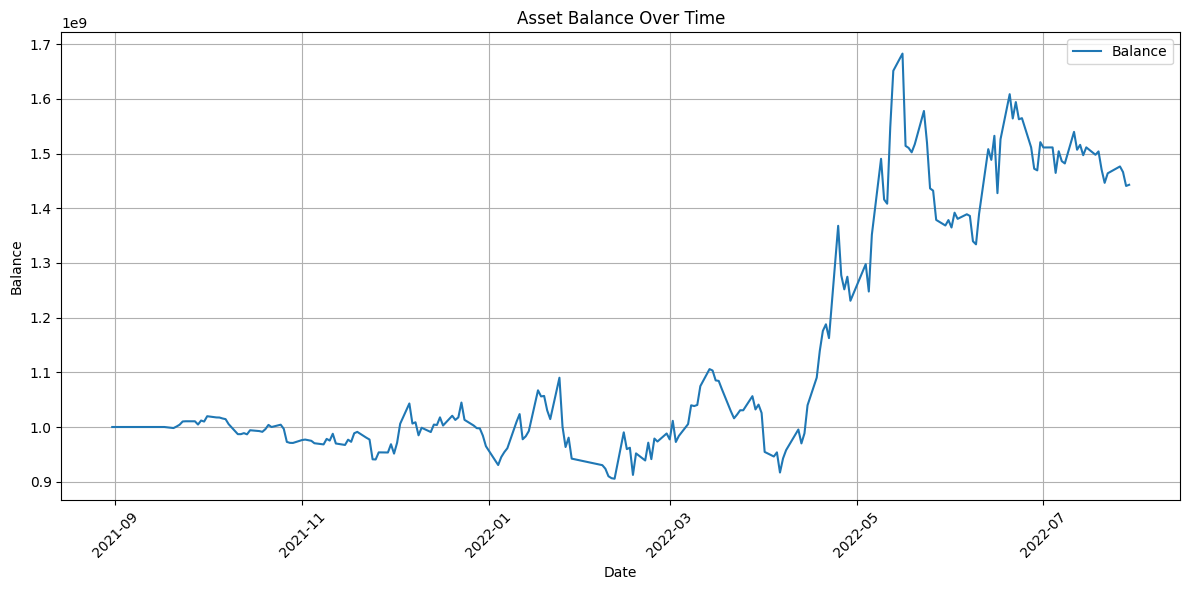

In [28]:
def plot_asset_balance(asset_df: pd.DataFrame):
    """
    Plots the 'balance' column of the given asset DataFrame using matplotlib.

    Args:
        asset_df (pd.DataFrame): DataFrame containing a 'balance' column and a 'Date' index.
    """
    if 'balance' not in asset_df.columns:
        print("Error: 'balance' column not found in the DataFrame.")
        return

    if not isinstance(asset_df.index, pd.DatetimeIndex):
        print("Error: DataFrame index is not a DatetimeIndex. Ensure 'Date' is the index.")
        return

    plt.figure(figsize=(12, 6))  # Adjust figure size as needed
    plt.plot(asset_df.index, asset_df['balance'], label='Balance')
    plt.title('Asset Balance Over Time')
    plt.xlabel('Date')
    plt.ylabel('Balance')
    plt.legend()
    plt.grid(True)  # Add grid lines for better readability
    plt.xticks(rotation=45) #rotate x axis labels
    plt.tight_layout() #avoid labels being cut off
    plt.show()


plot_asset_balance(asset_df)

# Real simulation

In [9]:
import pandas as pd
from datetime import timedelta

def generate_periods_df(vn30_stocks, window=60, add_etfs=False, etfs=None):
    """Generate a DataFrame of trading periods based on VN30 stock data, with the first start_date as '2021-06-01'.

    Args:
        vn30_stocks (pd.DataFrame): DataFrame with 'Date' index and 'Stock' column from get_vn30.
        window (int): Number of days to subtract from rebalancing date for start_date. Defaults to 60.
        add_etfs (bool): Whether to include ETFs in stock lists. Defaults to False.
        etfs (list): List of ETF ticker symbols to add if add_etfs is True. Defaults to None.

    Returns:
        pd.DataFrame: DataFrame with columns ['stocks_list', 'start_date', 'end_date'],
                      where the first start_date is '2021-06-01'.

    Raises:
        ValueError: If vn30_stocks is empty.
    """
    if vn30_stocks.empty:
        raise ValueError("No data found in vn30_stocks.")

    # Group stocks by date to get the list of stocks for each rebalancing date
    grouped = vn30_stocks.groupby('Date')['Stock'].apply(list)
    date_stock_pairs = [(date, stocks) for date, stocks in grouped.items()]

    # Generate periods
    periods = []
    for i, (current_date, current_stocks) in enumerate(date_stock_pairs):
        # Calculate start_date
        start_date = current_date - timedelta(days=window)

        # Override the first start_date to be '2021-06-01'
        if i == 0:
            start_date = pd.to_datetime('2021-06-01')

        # Determine end_date
        if i < len(date_stock_pairs) - 1:
            next_date = date_stock_pairs[i + 1][0]
            end_date = next_date - timedelta(days=1)
        else:
            end_date = pd.to_datetime('2025-01-01')  # Fixed end date for last period

        # Add ETFs if specified
        active_stocks = current_stocks.copy()
        if add_etfs and etfs:
            active_stocks.extend(etfs)
            active_stocks = list(dict.fromkeys(active_stocks))  # Remove duplicates, preserve order

        # Format dates as strings
        start_date_str = start_date.strftime('%Y-%m-%d')
        end_date_str = end_date.strftime('%Y-%m-%d')

        periods.append({
            'stocks_list': active_stocks,
            'start_date': start_date_str,
            'end_date': end_date_str
        })

    # Convert to DataFrame
    periods_df = pd.DataFrame(periods)
    return periods_df


# The run_backtest_for_periods function remains unchanged
def run_backtest_for_periods(periods_df, futures='VN30F1M'):
    """Run a backtest across all periods specified in periods_df.

    Args:
        periods_df (pd.DataFrame): DataFrame with ['stocks_list', 'start_date', 'end_date'] columns.
        futures (str): Futures symbol for backtesting. Defaults to 'VN30F1M'.

    Returns:
        tuple: (pd.DataFrame, pd.DataFrame)
            - combined_returns_df: Time series of daily returns.
            - combined_detail_df: Aggregated backtest details.
    """
    all_returns_dfs = []
    all_detail_dfs = []

    # Run backtest for each period
    for period_idx, period in periods_df.iterrows():
        active_stocks = period['stocks_list']
        start_date = period['start_date']
        end_date = period['end_date']

        print(f"Running backtest for period {period_idx + 1}: {start_date} to {end_date} "
              f"with stocks: {active_stocks}")

        # Initialize and run strategy
        data_handler = DataHandler(
            futures=futures,
            stocks=active_stocks,
            start_date=start_date,
            end_date=end_date
        )
        strategy = StatArbStrategy(data_handler)
        strategy.run_strategy()
        results_df_1, stock_price = strategy.get_results()

        # Process results
        results_df, positions_df, trading_log = process_results_df(
            results_df_1, stock_price, stocks=active_stocks
        )

        # Run backtest
        pm = PortfolioManager()
        asset_df, detail_df = pm.run_backtest(trading_log, stock_price)

        # Compute and store returns
        returns_df = asset_df['balance'].pct_change().fillna(0).to_frame(name='returns')
        all_returns_dfs.append(returns_df)
        all_detail_dfs.append(detail_df)

    # Aggregate results
    combined_returns_df = pd.concat(all_returns_dfs).sort_index()
    combined_returns_df = combined_returns_df[~combined_returns_df.index.duplicated(keep='first')]

    combined_detail_df = pd.concat(all_detail_dfs).sort_index()
    combined_detail_df = combined_detail_df[~combined_detail_df.index.duplicated(keep='first')]

    return combined_returns_df, combined_detail_df



In [24]:
def generate_periods_df(vn30_stocks, start_date, end_date, window=60, etf_list=None, etf_included=False):
    """Generate a DataFrame of trading periods based on VN30 stock data, with the first start_date as specified.

    Args:
        vn30_stocks (pd.DataFrame): DataFrame with 'Date' index and 'Stock' column from get_vn30.
        start_date (str): Desired start date for the first period in 'YYYY-MM-DD' format.
        end_date (str): End date for the last period in 'YYYY-MM-DD' format.
        window (int): Number of days to subtract from rebalancing date for start_date. Defaults to 60.
        etf_list (list): List of ETF ticker symbols to add if etf_included is True. Defaults to None.
        etf_included (bool): Whether to include ETFs in stock lists. Defaults to False.

    Returns:
        pd.DataFrame: DataFrame with columns ['stocks_list', 'start_date', 'end_date'],
                      where the first start_date matches the input start_date.

    Raises:
        ValueError: If vn30_stocks is empty.
    """
    if vn30_stocks.empty:
        raise ValueError("No data found in vn30_stocks.")

    # Group stocks by date to get the list of stocks for each rebalancing date
    grouped = vn30_stocks.groupby('Date')['Stock'].apply(list)
    date_stock_pairs = [(date, stocks) for date, stocks in grouped.items()]

    # Generate periods
    periods = []
    for i, (current_date, current_stocks) in enumerate(date_stock_pairs):
        # Calculate start_date
        start_date_calc = current_date - timedelta(days=window)

        # Override the first start_date to match the input start_date
        if i == 0:
            period_start_date = pd.to_datetime(start_date)
        else:
            period_start_date = start_date_calc

        # Determine end_date
        if i < len(date_stock_pairs) - 1:
            next_date = date_stock_pairs[i + 1][0]
            end_date_calc = next_date - timedelta(days=1)
        else:
            end_date_calc = pd.to_datetime(end_date)  # Use the provided end_date for the last period

        # Add ETFs if specified
        active_stocks = current_stocks.copy()
        if etf_included and etf_list:
            active_stocks.extend(etf_list)
            active_stocks = list(dict.fromkeys(active_stocks))  # Remove duplicates, preserve order

        # Format dates as strings
        start_date_str = period_start_date.strftime('%Y-%m-%d')
        end_date_str = end_date_calc.strftime('%Y-%m-%d')

        periods.append({
            'stocks_list': active_stocks,
            'start_date': start_date_str,
            'end_date': end_date_str
        })

    # Convert to DataFrame
    periods_df = pd.DataFrame(periods)
    return periods_df


def run_backtest_for_periods(periods_df, futures='VN30F1M', etf_list=None, etf_included=False):
    """Run a backtest across all periods specified in periods_df.

    Args:
        periods_df (pd.DataFrame): DataFrame with ['stocks_list', 'start_date', 'end_date'] columns.
        futures (str): Futures symbol for backtesting. Defaults to 'VN30F1M'.
        etf_list (list): List of ETF ticker symbols to pass to DataHandler. Defaults to None.
        etf_included (bool): Whether to include ETFs in DataHandler. Defaults to False.

    Returns:
        tuple: (pd.DataFrame, pd.DataFrame)
            - combined_returns_df: Time series of daily returns.
            - combined_detail_df: Aggregated backtest details.
    """
    all_returns_dfs = []
    all_detail_dfs = []

    # Run backtest for each period
    for period_idx, period in periods_df.iterrows():
        active_stocks = period['stocks_list']
        start_date = period['start_date']
        end_date = period['end_date']

        print(f"Running backtest for period {period_idx + 1}: {start_date} to {end_date} "
              f"with stocks: {active_stocks}")

        # Initialize and run strategy with etf_list and etf_included
        data_handler = DataHandler(
            futures=futures,
            stocks=active_stocks,
            start_date=start_date,
            end_date=end_date,
            etf_list=etf_list,
            etf_included=etf_included
        )
        strategy = StatArbStrategy(data_handler)
        strategy.run_strategy()
        results_df_1, stock_price = strategy.get_results()

        # Process results
        results_df, positions_df, trading_log = process_results_df(
            results_df_1, stock_price, stocks=active_stocks
        )

        # Run backtest
        pm = PortfolioManager()
        asset_df, detail_df = pm.run_backtest(trading_log, stock_price)

        # Compute and store returns
        returns_df = asset_df['balance'].pct_change().fillna(0).to_frame(name='returns')
        all_returns_dfs.append(returns_df)
        all_detail_dfs.append(detail_df)

    # Aggregate results
    combined_returns_df = pd.concat(all_returns_dfs).sort_index()
    combined_returns_df = combined_returns_df[~combined_returns_df.index.duplicated(keep='first')]

    combined_detail_df = pd.concat(all_detail_dfs).sort_index()
    combined_detail_df = combined_detail_df[~combined_detail_df.index.duplicated(keep='first')]

    return combined_returns_df, combined_detail_df

In [27]:
vn30_stocks=get_vn30('2021-06-01', '2025-01-10')
vn30_stocks.index = pd.to_datetime(vn30_stocks.index)

# Step 1: Generate the periods DataFrame with ETFs
etfs_list = [ 'FUEVFVND', 'FUESSVFL', 'E1VFVN30', 'FUEVN100']
periods_df = generate_periods_df(vn30_stocks, 
                                 start_date, 
                                 end_date, 
                                 window=60, etf_list=etfs_list, etf_included=False)

InterfaceError: connection already closed

In [42]:
periods_df.to_csv('data\\periods.csv')

In [36]:
# Step 2: Run the backtest using the periods DataFrame
combined_returns_df, combined_detail_df = run_backtest_for_periods(
    periods_df=periods_df,
    futures='VN30F1M'
)

Running backtest for period 1: 2021-06-01 to 2022-07-31 with stocks: ['ACB', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 'KDH', 'MBB', 'MSN', 'MWG', 'NVL', 'PDR', 'PLX', 'PNJ', 'POW', 'SAB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE', 'FUEVFVND', 'FUESSVFL', 'E1VFVN30', 'FUEVN100']


KeyError: 'Combination_ID'

In [ ]:
stocks=['ACB', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 'KDH', 'MBB', 'MSN', 'MWG', 'NVL', 'PDR', 'PLX', 'PNJ', 'POW', 'SAB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE','FUEVFVND', 'FUESSVFL', 'E1VFVN30', 'FUEVN100']
futures='VN30F1M'
start_date='2021-06-01'
end_date='2022-07-31'
etf_list = ['FUEVFVND', 'FUESSVFL', 'E1VFVN30', 'FUEVN100']


# Initialize DataHandler with ETF list and etf_included flag
data_handler = DataHandler(
    futures=futures,
    stocks=stocks, 
    start_date=start_date,
    end_date=end_date,
    etf_list=etf_list,
    etf_included=False  # Set to False to exclude ETFs entirely
)

# Run the strategy
strategy = StatArbStrategy(data_handler)
strategy.run_strategy()
results_df_1, stock_price = strategy.get_results()


KeyError: 'Combination_ID'

In [17]:
results_df_1

,Date,Combination_ID,Residual,Total_Combinations,Num_Stocks,Is_Estimation,Intercept,Beta_SAB,Beta_TPB,Beta_TCB,...,Beta_MBB,Beta_GVR,Beta_VNM,Beta_ACB,Beta_SSI,Beta_PNJ,Beta_BVH,Beta_GAS,Beta_KDH,Beta_PDR
0,2021-06-08,1,315.161481,1,3,True,-168.184269,4.803099,68.360858,1.096044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,2021-06-09,1,319.452549,1,3,True,-168.184269,4.803099,68.360858,1.096044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,2021-06-10,1,324.479266,1,3,True,-168.184269,4.803099,68.360858,1.096044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,2021-06-11,1,319.244931,1,3,True,-168.184269,4.803099,68.360858,1.096044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,2021-06-14,1,328.138924,1,3,True,-168.184269,4.803099,68.360858,1.096044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2443,2022-07-25,25,541.829629,8,5,True,-275.419666,NaN,NaN,NaN,...,NaN,NaN,2.8293,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2451,2022-07-26,25,543.113886,8,5,False,-275.419666,NaN,NaN,NaN,...,NaN,NaN,2.8293,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2458,2022-07-27,25,544.158321,7,5,False,-275.419666,NaN,NaN,NaN,...,NaN,NaN,2.8293,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2465,2022-07-28,25,543.302543,7,5,False,-275.419666,NaN,NaN,NaN,...,NaN,NaN,2.8293,NaN,NaN,NaN,NaN,0.0,0.0,0.0


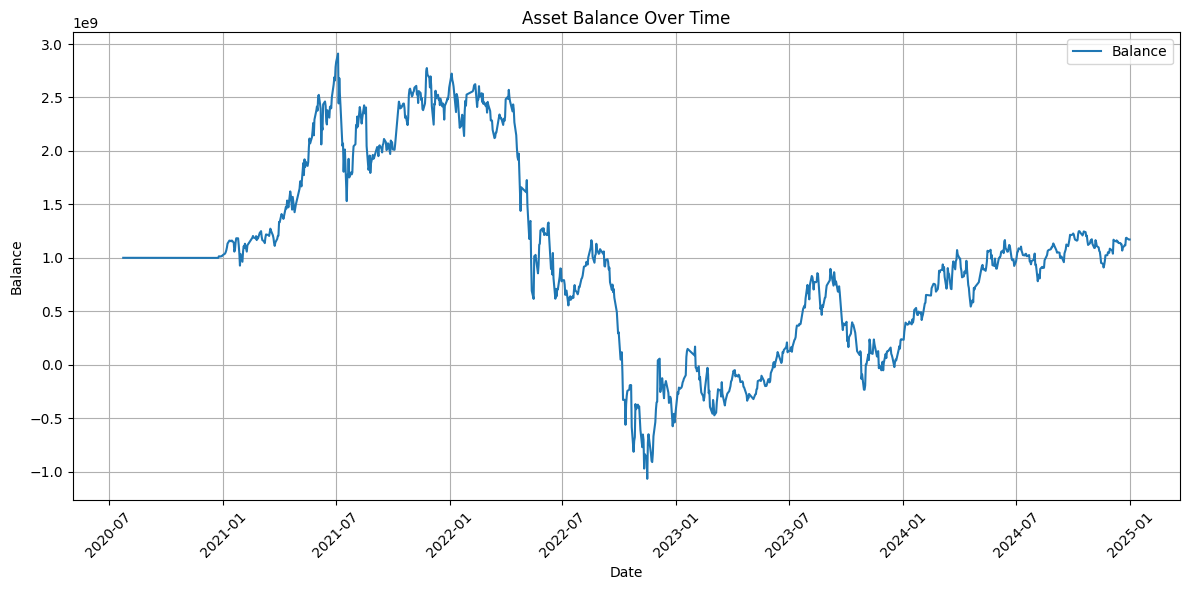

In [ ]:
plot_asset_balance(combined_returns_df)

# Evaluation

In [180]:
def calculate_metrics(asset_df: pd.DataFrame, benchmark_df: pd.DataFrame, risk_free_rate: float = 0.05) -> dict:
    """
    Calculate performance metrics using asset_df['balance'] and benchmark_df['close'].

    Args:
        asset_df (pd.DataFrame): Portfolio data with 'Date' index and 'balance' column.
        benchmark_df (pd.DataFrame): VN30F1M data with 'Date' index and 'close' column.
        risk_free_rate (float): Annual risk-free rate (default: 0.0).

    Returns:
        dict: Performance metrics.
    """
    common_dates = asset_df.index.intersection(benchmark_df.index)
    if len(common_dates) == 0:
        raise ValueError("No common dates between asset_df and benchmark_df.")
    asset_df = asset_df.loc[common_dates].copy()
    benchmark_df = benchmark_df.loc[common_dates].copy()

    asset_df['portfolio_return'] = asset_df['balance'].pct_change().fillna(0)
    benchmark_df['benchmark_return'] = benchmark_df['close'].pct_change().fillna(0)
    asset_df['cumulative_return'] = (1 + asset_df['portfolio_return']).cumprod() - 1
    benchmark_df['cumulative_benchmark_return'] = (1 + benchmark_df['benchmark_return']).cumprod() - 1

    hpr = asset_df['cumulative_return'].iloc[-1]
    benchmark_hpr = benchmark_df['cumulative_benchmark_return'].iloc[-1]
    excess_hpr = hpr - benchmark_hpr

    num_days = len(common_dates)
    if num_days < 2:
        raise ValueError("Insufficient data points for calculations.")
    annual_return = (1 + hpr) ** (252 / num_days) - 1
    benchmark_annual_return = (1 + benchmark_hpr) ** (252 / num_days) - 1
    annual_excess_return = annual_return - benchmark_annual_return

    peak = asset_df['balance'].cummax()
    drawdown = (asset_df['balance'] / peak - 1).min()
    mdd = drawdown if drawdown < 0 else 0

    in_drawdown = asset_df['balance'] < peak
    drawdown_periods = []
    start = None
    for i, is_dd in enumerate(in_drawdown):
        if is_dd and start is None:
            start = i
        elif not is_dd and start is not None:
            drawdown_periods.append(i - start)
            start = None
    if start is not None:
        drawdown_periods.append(i - start + 1)
    longest_drawdown = max(drawdown_periods) if drawdown_periods else 0

    # Turnover Ratio requires trading_log_df; omitted here for simplicity
    turnover_ratio = np.nan  # Placeholder

    annual_volatility = asset_df['portfolio_return'].std() * np.sqrt(252)
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility if annual_volatility != 0 else np.nan

    covariance = asset_df['portfolio_return'].cov(benchmark_df['benchmark_return'])
    benchmark_variance = benchmark_df['benchmark_return'].var()
    beta = covariance / benchmark_variance if benchmark_variance != 0 else np.nan

    downside_returns = asset_df['portfolio_return'][asset_df['portfolio_return'] < 0]
    downside_volatility = downside_returns.std() * np.sqrt(252)
    sortino_ratio = (annual_return - risk_free_rate) / downside_volatility if downside_volatility != 0 else np.nan

    excess_returns = asset_df['portfolio_return'] - benchmark_df['benchmark_return']
    tracking_error = excess_returns.std() * np.sqrt(252)
    information_ratio = annual_excess_return / tracking_error if tracking_error != 0 else np.nan

    return {
        'HPR': hpr,
        'Excess HPR': excess_hpr,
        'Annual Return': annual_return,
        'Annual Excess Return': annual_excess_return,
        'MDD': mdd,
        'Longest Drawdown': longest_drawdown,
        'Turnover Ratio': turnover_ratio,
        'Sharpe Ratio': sharpe_ratio,
        'Beta': beta,
        'Sortino Ratio': sortino_ratio,
        'Information Ratio': information_ratio
    }

In [181]:
calculate_metrics(asset_df, benchmark)

{'HPR': 0.15218801956220007,
 'Excess HPR': 0.10948808155848044,
 'Annual Return': 0.20551376964121082,
 'Annual Excess Return': 0.1487961960047015,
 'MDD': -0.2985663656677986,
 'Longest Drawdown': 57,
 'Turnover Ratio': nan,
 'Sharpe Ratio': 0.3482926571920581,
 'Beta': 2.7708566258522693,
 'Sortino Ratio': 0.4862106088022655,
 'Information Ratio': 0.4572621644010137}